# Customer Behaviour Insight Engine - Product Associations (Notebook 5)


This notebook explores **which products are frequently bought and viewed together**.

There are two main approaches:

1. **Order-based associations**
    - Look at which products appear together in the **same order**
    - Compute classic rule metrics: **support, confidence, lift**
    - Run the **Apriori** algorithm (via `mlxtend`) on a one-hot order-product matrix

2. **Session-based associations (co-views)**
    - Look at which products are **viewed in the same sessions**, even if not bought
    - Build a **product-product co-view matrix** and a **heatmap**
    - Extract a table of the **top co-viewed product pairs**

These analyses are typically used for: 

    - "Frequently bought together" suggestions
    - Cross-sell / bundle ideas
    - Understanding how customers **navigate** a product catalogue

## 1. Load cleaned order & prouct data

Load the cleaned tables for order-level analysis: 

- `orders_clean.csv` - one row per order 
- `order_items_clean.csv` - one row per order line (order-product)
- `products_clean.csv` product catalog

Build baskets and association rules from `order_items` and later connect to product info if necessary. 


In [ ]:

import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

processed_path = "../data/processed/"

# Load cleaned tables
orders = pd.read_csv(processed_path + "orders_clean.csv", parse_dates=["order_time"])
order_items = pd.read_csv(processed_path + "order_items_clean.csv")
products = pd.read_csv(processed_path + "products_clean.csv")

print("orders:", orders.shape)
print("order_items:", order_items.shape)
print("products:", products.shape)

orders.head()

orders: (33580, 10)
order_items: (59163, 5)
products: (1197, 6)


,order_id,customer_id,order_time,payment_method,discount_pct,subtotal_usd,total_usd,country,device,source
0,1,13917,2025-01-31 23:07:42,card,20,107.15,85.72,PL,desktop,organic
1,2,1022,2024-02-19 01:17:50,card,0,116.17,116.17,FR,tablet,organic
2,3,6145,2024-12-04 20:24:13,card,0,137.35,137.35,US,mobile,organic
3,4,3152,2024-07-17 08:50:47,card,15,32.18,27.35,BR,mobile,email
4,5,12378,2020-08-21 16:54:16,card,0,238.09,238.09,NL,desktop,paid


## 2. Build product baskets per order 

Goal: **one row per oder with a list of products in that order.**

Steps: 
    - Drop any `order_items` rows without a valid `product_id`
    - Cast `product_id` to `int`
    - Group by `order_id` and aggregate `product_id` inot a Python `list`

Result: a `baskets` DataFrame with: 

    - `order_id`
    - `products` -> e.g. `[405, 487, 442, 348]`

This is a typical **"basket"** representation for market basket analysis.

In [ ]:
#Keep only oders with valid product_id
order_items = order_items.dropna(subset=["product_id"])

#cast product_id to int
order_items["product_id"] = order_items["product_id"].astype(int)

# Group by order and collect products into a list 
baskets= (
    order_items
    .groupby("order_id")["product_id"]
    .apply(list)
    .reset_index(name="products")

)

baskets.head(10)

,order_id,products
0,1,[226]
1,2,[771]
2,3,"[415, 24]"
3,4,[1157]
4,5,"[846, 745]"
5,6,"[123, 888]"
6,7,"[405, 487, 442, 348]"
7,8,[949]
8,9,"[613, 755, 1078]"
9,10,[769]


## 3. Single-product frequencies (support)

Measure **how common each product is across orders**. 

    - `n_orders` = total number of orders in the `baskets` table
    - `explode` the `products` list so we get one row per order `(order_id, product_id)`
    - For each `product_id`, count how many **distinct orders** it appears in -> `order_count`
    - **Support** is defined as: 

   \[
\text{support(product)} = \frac{\text{# of orders containing product}}{\text{total # of orders}}
\]

This gives a baseline for how frequently each product is purchased.

In [54]:
# Total number of orders
n_orders = len(baskets)
print("Total orders:", n_orders)

# Explode lists so each row is one (order_id, product_id)
exploded = baskets.explode("products").rename(columns={"products": "product_id"})

# Count distinct orders each product appears in
product_counts = (
    exploded.groupby("product_id")["order_id"]
    .nunique()
    .reset_index(name="order_count")
)

# Compute support measure
product_counts["support"] = product_counts["order_count"] / n_orders

product_counts.head()

Total orders: 33580


,product_id,order_count,support
0,1,2,0.000060
1,2,2,0.000060
2,3,4,0.000119
3,4,14,0.000417
4,5,44,0.001310


## 4. Order-based product pairs with Pandas

Examine the **pairs of products that appear together in the same order**. 

For each order: 

    - Take the **set of unique products** (so duplicates in the same order don't inflate counts)
    - Use `itertools.combinations(..., 2)` to generate all possible product pairs `(A, B)` in that order 
    - Count how many orders each pair appear in -> `pair_count`

Simple, fully transparent co-occurnce calculation using only Pandas + Python

In [15]:
from itertools import combinations
from collections import Counter

pair_counter = Counter()

for products_list in baskets["products"]:
    unique_products = sorted(set(products_list))
    for combo in combinations(unique_products, 2):
        pair_counter[combo] += 1

pair_df = (
    pd.DataFrame(
        [(a, b, count) for (a, b), count in pair_counter.items()],
        columns=["product_a", "product_b", "pair_count"]
    )
)

pair_df.head()

,product_a,product_b,pair_count
0,24,415,1
1,745,846,1
2,123,888,1
3,348,405,1
4,348,442,1


## 5. Rule metrics: support, confidence lift (Pandas)

Using the pair counts and single-product supports, we compute association rule metrics for the rule **A → B**:

- **Pair support**  
  support(A,B) = (# orders containing both A and B) / (total # orders)

- **Confidence (A → B)** – “If someone buys A, how often do they also buy B?”  
  confidence(A → B) = support(A,B) / support(A)

- **Lift (A → B)** – “How much more likely is B when A is present, compared to chance?”  
  lift(A → B) = support(A,B) / (support(A) * support(B))

We then filter to rules with relatively strong signals, e.g.:

- `support_ab >= 0.01`
- `confidence_A_to_B >= 0.3`
- `lift_A_to_B >= 1.0` (positive association)

In this dataset, these thresholds are intentionally strict, so only very strong patterns (if any) would pass.

In [17]:
# Merge product supports onto pairs
pair_with_support = (
    pair_df
    .merge(
        product_counts[["product_id", "support"]].rename(
            columns={"product_id": "product_a", "support": "support_a"}
        ),
        on="product_a",
        how="left"
    )
    .merge(
        product_counts[["product_id", "support"]].rename(
            columns={"product_id": "product_b", "support": "support_b"}
        ),
        on="product_b",
        how="left"
    )
)

pair_with_support["support_ab"] = pair_with_support["pair_count"] / n_orders

# Avoid division by zero
pair_with_support = pair_with_support[
    (pair_with_support["support_a"] > 0) &
    (pair_with_support["support_b"] > 0)
]

# Confidence and lift for rule A → B
pair_with_support["confidence_A_to_B"] = (
    pair_with_support["support_ab"] / pair_with_support["support_a"]
)

pair_with_support["lift_A_to_B"] = (
    pair_with_support["support_ab"] /
    (pair_with_support["support_a"] * pair_with_support["support_b"])
)

pair_with_support.head()

,product_a,product_b,pair_count,support_a,support_b,support_ab,confidence_A_to_B,lift_A_to_B
0,24,415,1,0.002561,0.001429,0.00003,0.011628,8.134690
1,745,846,1,0.000566,0.002412,0.00003,0.052632,21.819363
2,123,888,1,0.001846,0.001668,0.00003,0.016129,9.671659
3,348,405,1,0.000864,0.002740,0.00003,0.034483,12.586207
4,348,442,1,0.000864,0.003693,0.00003,0.034483,9.338154


In [19]:
rules_pandas = (
    pair_with_support
    .query("support_ab >= 0.01 and confidence_A_to_B >= 0.3 and lift_A_to_B >= 1.0")
    .sort_values("lift_A_to_B", ascending=False)
)

rules_pandas.head(10)

,product_a,product_b,pair_count,support_a,support_b,support_ab,confidence_A_to_B,lift_A_to_B


In [23]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 44.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [mlxtend]m4/5 [mlxtend]earn]


## 6. Apriori-based association rules (mlextend)

Use the `mlxtend` implementaion of **Apriori** on a one-hot encoded order-product matrix: 

1. Build `basket_matrix`:
    - Rows: `order_id`
    - Columns: `product_id`
    - Values: `True/False` indicating whether a product appears in that order 

2. Run `apriori` with:
    - `min_support = 0.002`
    -` max_len = 2` (only include single products and pairs)
    - `use_colnames = True` to get product IDs in the itemsets

3. Sort frequent itemsets by support. 

### Important observation

Apriori mostly returns **single-item** sets, not frequent pairs. 
This is consisten with the structure of the data: 

- Most orders contain **only one product (median basket size = 1)**
- Product pairs rarely repeat across many orders
- As a result very few combinations reach the `min_support` threshold 

This is a realisitic outcome in many e-commerce settings where the "basket" is often a single item.

In [28]:
from mlxtend.frequent_patterns import apriori, association_rules

# Re-use 'exploded' from before (order_id, products)
basket_matrix = (
    exploded
    .assign(value=True)
    .pivot_table(
        index="order_id",
        columns="product_id",
        values="value",
        aggfunc="max",
        fill_value=False
    )
)

basket_matrix.head()

product_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
frequent_itemsets = apriori(
    basket_matrix,
    min_support=0.002,
    use_colnames=True,
    max_len=2
)

frequent_itemsets.sort_values("support", ascending=False).head(10)

,support,itemsets
91,0.004139,(496)
72,0.003663,(442)
60,0.003633,(404)
166,0.003395,(861)
57,0.003365,(392)
45,0.003306,(358)
146,0.003306,(769)
48,0.003306,(366)
94,0.003306,(504)
308,0.003306,(1148)


In [37]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

processed_path = "../data/processed/"

# Load events_clean
events = pd.read_csv(
    processed_path + "events_clean.csv",
    parse_dates=["timestamp"]
)

print("events:", events.shape)
events.head()

events: (760958, 10)


,event_id,session_id,timestamp,event_type,product_id,qty,cart_size,payment,discount_pct,amount_usd
0,1,1,2021-12-27 00:08:36,page_view,93.0,NaN,NaN,NaN,NaN,NaN
1,2,1,2021-12-27 00:16:36,page_view,1005.0,NaN,NaN,NaN,NaN,NaN
2,3,1,2021-12-27 00:18:01,add_to_cart,1005.0,1.0,NaN,NaN,NaN,NaN
3,4,1,2021-12-27 00:45:36,page_view,918.0,NaN,NaN,NaN,NaN,NaN
4,5,1,2021-12-27 01:03:36,page_view,946.0,NaN,NaN,NaN,NaN,NaN


In [41]:
# --- 5B: Session-based product co-view matrix ---
## Which products tend to be seen in the same sesion?

# Filter to page views only
views = events[events["event_type"] == "page_view"]

# Group views by session and list product_ids
session_product_views = (
    views.groupby("session_id")["product_id"]
    .apply(lambda x: list(x.dropna().astype(int)))
    .reset_index(name="products_viewed")
)

session_product_views.head()

,session_id,products_viewed
0,1,"[93, 1005, 918, 946, 915, 931, 978]"
1,2,"[929, 226, 864, 1151, 855]"
2,3,"[771, 743]"
3,4,"[1043, 918]"
4,5,"[273, 832, 591, 635, 398, 892]"


In [40]:
from collections import Counter
import itertools

pair_counts = Counter()

for products in session_product_views["products_viewed"]:
    unique_products = set(products)
    for a, b in itertools.combinations(sorted(unique_products), 2):
        pair_counts[(a, b)] += 1

# Convert to DataFrame
pair_df = (
    pd.DataFrame(
        [(a, b, count) for (a, b), count in pair_counts.items()],
        columns=["product_A", "product_B", "co_views"]
    )
    .sort_values("co_views", ascending=False)
)

pair_df.head(10)

,product_A,product_B,co_views
35117,288,300,25
2993,429,461,24
86084,670,671,23
85774,1029,1049,22
15959,541,678,22
26893,1137,1180,22
35511,404,442,21
74807,1101,1186,21
72782,358,377,21
25806,231,271,21


In [42]:
# Product view counts 
product_view_counts = views["product_id"].value_counts().to_dict()

pair_df["support_A"] = pair_df["product_A"].map(product_view_counts)
pair_df["support_B"] = pair_df["product_B"].map(product_view_counts)

pair_df["affinity"] = pair_df["co_views"] / pair_df[["support_A", "support_B"]].min(axis=1)

pair_df.sort_values("affinity", ascending=False).head(10)

,product_A,product_B,co_views,support_A,support_B,affinity
45419,10,135,17,528,302,0.056291
67431,601,672,15,595,272,0.055147
76442,27,64,13,573,245,0.053061
118029,38,82,11,628,208,0.052885
96620,21,55,11,209,574,0.052632
117354,55,58,12,574,230,0.052174
25708,58,121,12,230,667,0.052174
219731,12,101,11,214,608,0.051402
43849,14,48,14,581,277,0.050542
107591,27,88,11,573,221,0.049774


## Co-occurence Heatmap (order-based)

To visually confrim the sparsity of the order-level associations: 

1. Select the **top N most purchased products** by support. 
2. Build a subset of the order-product matrix (`subset`) with only these products. 
3. Computer a co-purchase matrix: 

    - Rows and columns: product IDs
    - Cell (i, j): # of orders that contain **both** product i and product j. 

4. Plot a heatmap of co-purchase counts. 

Interpreation:

- Even among the **top 20** most-purchased products, co-purchases are very rare. 
- Most cells are 0 or very small counts. 
- There are **no clear high-strength product clusters** at the order level. 

This visually supports the Aprioro result: 
**orders are usually single-product**, so pure basket-based recommendations are weak in this dataset. 

This motivates a pivot to **session-based behaviour**, where customers view multiple products even if they only buy one. 



In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

processed_path = "../data/processed/"

orders = pd.read_csv(processed_path + "orders_clean.csv")
order_items = pd.read_csv(processed_path + "order_items_clean.csv")

# Build baskets: one list of product_ids per order
baskets = (
    order_items
    .groupby("order_id")["product_id"]
    .apply(lambda x: list(x.dropna().astype(int)))
    .reset_index(name="products")
)

# Total number of orders
n_orders = len(baskets)
print("Total orders:", n_orders)

# Explode to one row per (order_id, product_id)
exploded = baskets.explode("products")  # column is still called "products"

# Count orders per product and support
product_counts = (
    exploded["products"]
    .value_counts()
    .reset_index(name="order_count")
    .rename(columns={"index": "product_id"})
)

product_counts["support"] = product_counts["order_count"] / n_orders
product_counts.head()

Total orders: 33580


,products,order_count,support
0,496,139,0.004139
1,442,124,0.003693
2,404,122,0.003633
3,861,115,0.003425
4,392,113,0.003365


In [55]:
# ---- Build a co-purchase matrix for the top N products ----

top_n = 20  # you can change this to 15, 25, etc.

top_products = (
    product_counts
    .sort_values("support", ascending=False)
    .head(top_n)["product_id"]
    .tolist()
)

# Subset the basket matrix to just those products
subset = basket_matrix[top_products]

# Co-purchase counts: for each product pair (i, j), how many orders contain both?
co_counts = subset.T.dot(subset)

# Convert counts to support (fraction of all orders)
co_support = co_counts / n_orders

co_support

product_id,496,442,404,861,392,504,769,366,358,1148,944,265,1087,869,669,741,485,891,926,231
product_id,,,,,,,,,,,,,,,,,,,,
496,0.00003,0.00000,0.00003,0.00003,0.00000,0.00003,0.00003,0.00003,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000
442,0.00000,0.00003,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000
404,0.00003,0.00003,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00003,0.00000,0.00003,0.00000,0.00003,0.00000
861,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00003,0.00000
392,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00003,0.00000,0.00000,0.00003,0.00003,0.00003,0.00000,0.00003,0.00000
504,0.00003,0.00003,0.00003,0.00000,0.00000,0.00003,0.00003,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000
769,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
366,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00003,0.00003,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00000,0.00000
358,0.00000,0.00000,0.00000,0.00000,0.00003,0.00003,0.00000,0.00003,0.00003,0.00003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00000


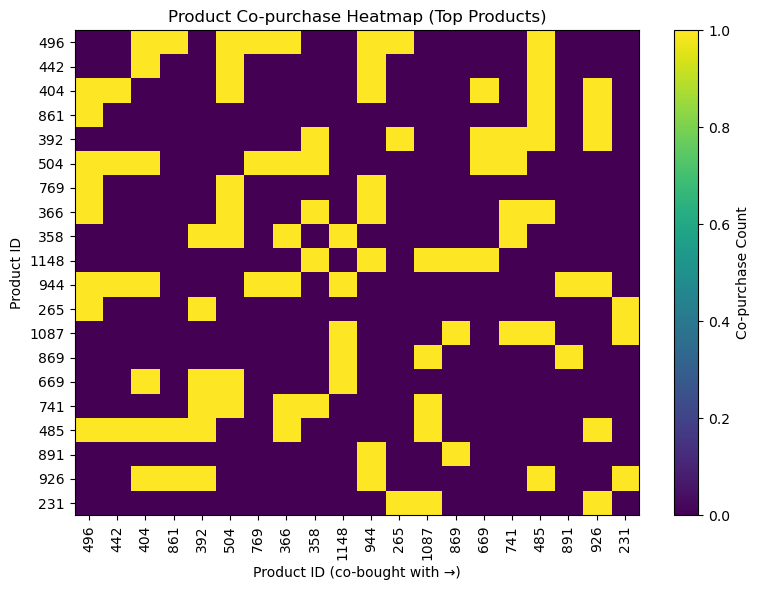

In [63]:
# ---- Plot the co-purchase heatmap ----

# Co-purchase counts matrix
co_counts = subset.T.dot(subset)

# Zero out the diagonal (product with itself)
np.fill_diagonal(co_counts.values, 0)

plt.figure(figsize=(8, 6))

np.fill_diagonal(co_counts.values, 0)

plt.imshow(co_counts, aspect="auto", cmap="viridis")
plt.colorbar(label="Co-purchase Count")

plt.xticks(range(len(top_products)), top_products, rotation=90)
plt.yticks(range(len(top_products)), top_products)

plt.title("Product Co-purchase Heatmap (Top Products)")
plt.xlabel("Product ID (co-bought with →)")
plt.ylabel("Product ID")
plt.tight_layout()
plt.show()

## 7. Switching to session-based analysis +  Load events and build a session_based product co-view matrix 

Because order-based Apriori doesn’t reveal strong product combinations (orders are too small), switch from:

- “**What gets purchased together?**”
to
- “**What gets viewed together in the same browsing session?**”

Session-level co-views can reveal **stronger affinities** between products, even if customers only purchase a single item.

In the next steps:

- Use `events_clean.csv` (event-level logs) to build a **session × product** view.
- Analyse which products tend to be **viewed together** in the same session.
- Visualise this with a co-view heatmap and a table of top pairs.
To normalise co-views by how often the **less-viewed** product appears.


In [ ]:

views = events[events["event_type"] == "page_view"].copy()

# How many *distinct* products are viewed per session?
session_view_counts = (
    views.groupby("session_id")["product_id"]
    .nunique()
    .reset_index(name="n_products_viewed")
)

session_view_counts["n_products_viewed"].describe()

count    120000.000000
mean          4.468017
std           2.277196
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max           8.000000
Name: n_products_viewed, dtype: float64

Distribution shows: 

- Median 4 products viewed per session
- Many sessions contain **4-6 distinct products**

Session-level data is **much richer** than order-level baskets for analysing product relationships. 

In [73]:
# How common are different session sizes?

session_view_counts["n_products_viewed"].value_counts().sort_index().head(10)

n_products_viewed
1    15150
2    15028
3    15260
4    15157
5    15205
6    14983
7    15111
8    14106
Name: count, dtype: int64

## 8. Build co-view matrix for top viewed products

1. Take the **top N most viewed products** overall.
2. Build a **session × product** one-hot matrix for these products:
   - Rows: `session_id`
   - Columns: product IDs
   - Values: 0/1 → whether the product was viewed in that session.

3. Compute a co-view matrix:

   - Rows and columns: product IDs
   - Cell (i, j): # of **sessions** where both i and j were viewed at least once.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 6. Session-based co-view heatmap (top viewed products)

# 6.1 Top N most viewed products
top_n = 20

product_view_counts = (
    views["product_id"]
    .dropna()
    .astype(int)
    .value_counts()
)

top_viewed_products = product_view_counts.head(top_n).index.tolist()
print("Top viewed products:", top_viewed_products)

# 6.2 Build a session x product one-hot matrix for these products
session_product_long = (
    session_product_views
    .explode("products_viewed")
    .dropna(subset=["products_viewed"])
)

session_product_long["products_viewed"] = session_product_long["products_viewed"].astype(int)

# Keep only the top viewed products
session_product_long = session_product_long[
    session_product_long["products_viewed"].isin(top_viewed_products)
]

session_onehot = (
    session_product_long
    .assign(value=True)
    .pivot_table(
        index="session_id",
        columns="products_viewed",
        values="value",
        aggfunc="max",
        fill_value=False   # currently booleans
    )
)

# Ensure consistent column order
session_onehot = session_onehot.reindex(columns=top_viewed_products, fill_value=False)

print("session_onehot shape:", session_onehot.shape)

session_onehot_int = session_onehot.astype(int)

# 6.3 Co-view counts matrix: how many sessions viewed both i and j?
co_view_counts = session_onehot_int.T.dot(session_onehot_int)

# Zero out diagonal (product with itself)
np.fill_diagonal(co_view_counts.values, 0)

co_view_counts.head()

Top viewed products: [1028, 1148, 678, 442, 231, 1039, 911, 769, 1087, 377, 980, 405, 404, 669, 458, 1017, 416, 910, 372, 485]
session_onehot shape: (13835, 20)


products_viewed,1028,1148,678,442,231,1039,911,769,1087,377,980,405,404,669,458,1017,416,910,372,485
products_viewed,,,,,,,,,,,,,,,,,,,,
1028,0,13,4,3,5,15,1,1,15,2,4,2,1,1,2,3,2,4,3,3
1148,13,0,4,0,4,16,3,1,10,2,3,5,5,4,4,5,5,4,2,2
678,4,4,0,3,5,3,4,3,3,6,2,4,1,14,1,2,2,4,3,4
442,3,0,3,0,2,3,4,2,2,14,2,10,21,2,13,8,14,2,8,11
231,5,4,5,2,0,5,3,8,1,2,7,3,3,1,4,4,4,5,6,1


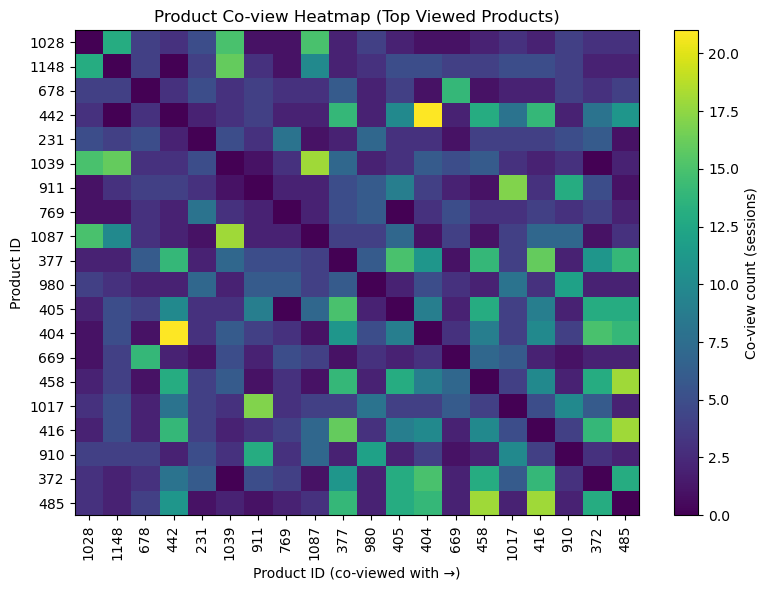

In [77]:
# 6.4 Plot the co-view heatmap

plt.figure(figsize=(8, 6))

plt.imshow(co_view_counts, aspect="auto")
plt.colorbar(label="Co-view count (sessions)")

plt.xticks(
    ticks=range(len(top_viewed_products)),
    labels=top_viewed_products,
    rotation=90
)
plt.yticks(
    ticks=range(len(top_viewed_products)),
    labels=top_viewed_products
)

plt.title("Product Co-view Heatmap (Top Viewed Products)")
plt.xlabel("Product ID (co-viewed with →)")
plt.ylabel("Product ID")
plt.tight_layout()
plt.show()

# 8.1 Top co-viewed product pairs (table)

To make the co-view patterns easier to use: 

- Convert the co-view matrix into a long-form table:
    - `product_A`
    - `product_B`
    - `co_view_count` = # sessions that viewed both

- Sort by `co_view_count` to find the most freuqently co-viewed paris among the top products 

These pairs are strong canditates for: 

- "Cusstomers also viewed..." recoomendations 
- Collection pages or carousels combining related products 
- Follow-up content suggestions in the browsing journey 


In [ ]:

pairs = []

for i, prod_i in enumerate(top_viewed_products):
    for j, prod_j in enumerate(top_viewed_products):
        if j <= i:
            continue  # avoid duplicates and self-pairs
        
        count = co_view_counts.iloc[i, j]
        
        if count > 0:  # keep only meaningful pairs
            pairs.append((prod_i, prod_j, count))

# Create DataFrame
co_view_table = (
    pd.DataFrame(pairs, columns=["product_A", "product_B", "co_view_count"])
    .sort_values("co_view_count", ascending=False)
    .reset_index(drop=True)
)

co_view_table.head(20)  # show top 20

,product_A,product_B,co_view_count
0,442,404,21
1,1039,1087,18
2,416,485,18
3,458,485,18
4,911,1017,17
5,377,416,16
6,1148,1039,16
7,377,405,15
8,404,372,15
9,1028,1087,15


## 9 Summary 

- **Order-based analysis (purchaess)**
    - Built product baskets per order and computed product supports.
    - Derived pair-evel support, confidence, and lift using Pandas. 
    - Ran Apriori (mlextend) on an order-product one-hot matrix.
    - Result: orders are usually **single-product**, so there are **no strong "frequntly bought together" pairs**; the co-purchase heatmap confirms this sparsity. 

-**Session-based analysis (co-views)**
    - Switched to event-level data (`events_clean`) and focused on product page views.
    - Found that sessions typically contain **4-6 distinct product views**, giving rich co-view signals. 
    - Built a session x product one-hot matrix, and visualised it as a heatmap. 
    - Extracted a ranked table of top co-viewed product pairs. 

**Takeaway:**
For this dataset, **order-based association rules are weak** because customers usually buy only one product per order. 
However, **session-based co-views** reveal meaningful product relationships that can be used for: 

    - "Customers also viewed" modules
    - Smarter product recommendataions 
    - Designing navigation and content to reflect how users actually browse the catalogue. 